In [34]:
"""
CS 677 Data Science with Python
#########################################
Module          - HW 5
Creation Date   - 03/03/2019
Student Name    - Gautam Gowrishankar
"""
import os
import pandas as pd
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from statistics import median,mean

#input file 
input_dir = r'/Users/arun/Downloads/CS677 - PY/'
input_file  = os.path.join(input_dir, 'GPS_MOD.csv')


df = pd.read_csv(input_file)
df.head(5)

,Date,Year,Month,Day,Weekday,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2014-01-02,2014,1,2,Thursday,39.630001,38.660000,38.720001,4785200.0,32.561630,0.000000,32.561630,32.561630
1,2014-01-03,2014,1,3,Friday,39.750000,38.730000,39.520000,4437000.0,33.234386,0.020661,32.898008,32.898008
2,2014-01-06,2014,1,6,Monday,39.630001,38.799999,39.049999,4514200.0,33.006180,-0.006867,32.934066,32.934066
3,2014-01-07,2014,1,7,Tuesday,39.990002,39.090000,39.340000,6683300.0,33.251289,0.007426,33.013371,33.013371
4,2014-01-08,2014,1,8,Wednesday,39.330002,38.619999,39.200001,6951600.0,33.132961,-0.003559,33.037289,33.037289


In [35]:
""""
#Task 1: Identifying the best n value for KNN classifier
"""
#Note: Considering the whole dataset for processing for achieving better accuracy 
#i.e. all the four years of data are split in to test and train and not restricting to any particular year
df2 = df[df["Weekday"]=="Thursday"].copy() #Since my input starts on a thursday, consider it as 1st day of week 
df2['idx'] = df2.index - 1
df2['idx'] = df2["idx"].shift(-1) #index of week's ending day
df2["idx"].fillna((len(df)-1),inplace=True) #fix the last value, since we are shifting up
df2.drop(df2.columns.difference(['Adj Close','Return','idx']),1,inplace=True)

#Calulate the weekly returns
#Idx column in df2 is nothing but the index of a particular week's last day
#Actual index 'i' and 'idx' from df2 together form the boundaries of a week
weeklyReturns = []
indices = []
for i,r in df2.iterrows():
    returns = 100*((df["Adj Close"].loc[r["idx"]] - df["Adj Close"].loc[i])/df["Adj Close"].loc[i])
    weeklyReturns.append(round(returns,3))
    indices.append((i,r["idx"]))

#Calculating the weekly mean, standard deviation and creating a df from that info
week = 1
dicts = {}
for x,y in indices:
    dicts[week] = (df["Return"][x:int(y)].mean(),df["Return"][x:int(y)].std())
    week +=1

#Labeling Rationale: 
#If the mean returns for a particular week is positive, 
#label it as a favourable one i.e. Green else Red
dfResult = pd.DataFrame.from_dict(dicts, orient='index').reset_index()
dfResult.columns = ['Week','Mean','S.Dev']
dfResult['Label'] = dfResult['Mean'].apply(lambda x: 'Red' if x < 0 else 'Green') #labeling
dfResult.tail(5)

,Week,Mean,S.Dev,Label
249,250,0.012858,0.027114,Green
250,251,0.002278,0.019928,Green
251,252,-0.017655,0.022891,Red
252,253,-0.006493,0.010713,Red
253,254,-0.003750,0.022830,Red


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#Pre-processing begins
X = dfResult[['Mean', 'S.Dev']].values
Y = dfResult[['Label']].values

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, shuffle = False, stratify = None)
print("Length of training dataset: {}".format(len(X_train)))
print("Length of test dataset: {}".format(len(X_test)))


Length of training dataset: 190
Length of test dataset: 64


The least error rate is: 0.015625 whose K-Value is: 1


Text(0, 0.5, 'Error Rate')

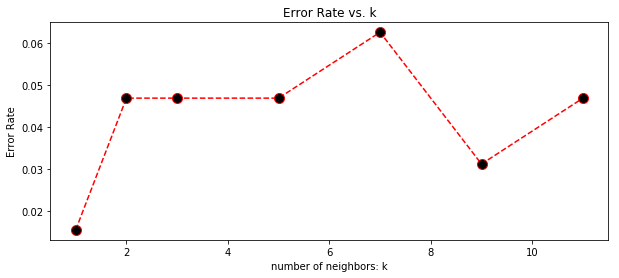

In [38]:
from operator import itemgetter
#Run through KNN for different neighbor values
err = []
val = [1, 2, 3, 5, 7, 9, 11]
for k in val:
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train, Y_train)
    pred = knn_classifier.predict(X_test)
    err.append(np.mean(pred != Y_test))
print('The least error rate is:',min(err),'whose K-Value is:',val[min(enumerate(err), key=itemgetter(1))[0]])

plt.figure(figsize = (10, 4))
plt.plot(val, err , color='red', linestyle='dashed',
            marker='o', markerfacecolor='black', markersize=10) 
plt.title('Error Rate vs. k')
plt.xlabel('number of neighbors: k')
plt.ylabel('Error Rate')

In [39]:
#Assessing the fit
#Extracting only the first week value for the sake of prediction
target = X[0:1]
actual = Y[0]

#Using the best neighbor value '1'
knn_classifier = KNeighborsClassifier(n_neighbors = 1)
knn_classifier.fit(X_train, Y_train)
predicted = knn_classifier.predict(target)

#Checking the predicted label
if predicted == actual:
    print('Prediction is true',le.inverse_transform(predicted))

Prediction is true ['Green']
